# Lab 2. Regularization

## L2.1. German Credit dataset.

* The `german_credit_numeric` dataset is available in the `tensorflow_datasets` package.
* This dataset classifies people described by a set of attributes as _good_ or _bad_ credit risks.
* The version here is the _numeric_ variant where categorical and ordered categorical attributes have been encoded as indicator and integer quantities respectively.
* The dataset has 24 numerical features and one numerical output in which a `0` corresponds to bad credit risk and a `1` corresponds to good credit risk.
* More information in: https://www.tensorflow.org/datasets/catalog/german_credit_numeric

In [1]:
import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import random

# We set the seed to be able to reproduce the results.
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# We load the data set
ds_train = tfds.load('german_credit_numeric', split='train[:40%]',  as_supervised=True).batch(128)
ds_val = tfds.load('german_credit_numeric', split='train[40%:50%]', as_supervised=True).batch(128)
ds_test = tfds.load('german_credit_numeric', split='train[50%:]', as_supervised=True).batch(128)

C:\Users\gianluca\Desktop\DEEP LEARNING NOTEBOOKS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/ url]
Dl Size...: 0 MiB [00:01, ? MiB/s]
Generating splits...:   0%|                                                                 | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
                                                              
Shuffling C:\Users\gianluca\tensorflow_datasets\german_credit_numeric\incomplete.2HAFCF_1.0.0\german_credit_numeric-tra
                                                                                                                       

Dataset german_credit_numeric downloaded and prepared to C:\Users\gianluca\tensorflow_datasets\german_credit_numeric\1.0.0. Subsequent calls will reuse this data.


## L2.2. Using a `Sequential` model

In [3]:
# We indicate the loss function, the optimization algorithm and the metrics to evaluate performance.
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)
metric = keras.metrics.AUC()

In [4]:
input_size = 24
h0_size = 20
h1_size = 10
h2_size = 5

# Define the sequential model
model = keras.Sequential()

# Include the input layer, 3 hidden dense layers and the output layer of the model
model.add(layers.Input(shape=(input_size,)))
model.add(layers.Dense(units=h0_size, activation='relu'))
model.add(layers.Dense(units=h1_size, activation='relu'))
model.add(layers.Dense(units=h2_size, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

# We build the model and show it 
model.build()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771 (3.01 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Indicate the parameters of the compile method
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [6]:
# We set the number of epochs
num_epochs = 700

# We save the weights before training, so that we can reset the model later and make comparisons.
training_weights = model.get_weights()

# Train the model
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, verbose=0)

In [7]:
import matplotlib.pyplot as plt

def plot_no_dots(history):
    plt.clf()
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.plot(epochs, history.history['loss'], 'b-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation loss') 

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

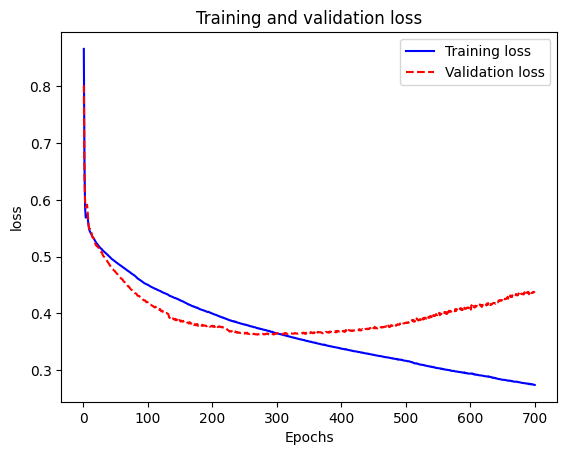

In [8]:
plot_no_dots(history)

In [9]:
# Call evaluate, saving the result
result = model.evaluate(ds_test, verbose=0) 
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[0.7653965950012207, 0.7238293886184692]


## L2.3. Using `EarlyStopping` 

In [10]:
# Indicates the measurement to be monitored, the mode and patience
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50
)

# Before training, we forget the previous training by restoring the initial weights.
model.set_weights(training_weights)

# Complete the fit method
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, verbose=0, callbacks=[es])

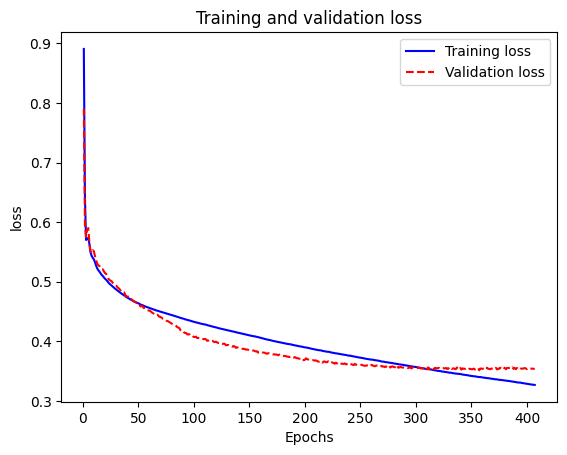

In [11]:
plot_no_dots(history)

In [12]:
# Call evaluate
result = model.evaluate(ds_test, verbose=0) 
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[0.6748670935630798, 0.7398185133934021]


## L2.4. Using weight regularization

In [13]:
# Uncomment the regularizing term to be used
from keras.regularizers import l2
#from keras.regularizers import l1

input_size = 24
# Modify the value of alpha to adjust the regularization.
alpha = 0.01
h0_size = 20
h1_size = 10
h2_size = 5

# Define the sequential model
model = keras.Sequential()

# Include the input layer
model.add(layers.Input(shape=(input_size,)))

# Include the units of the first Dense layer and the regularizer
model.add(layers.Dense(units=h0_size, kernel_regularizer=l2(alpha), activation='relu'))

# Includes the regularizer in the different layers
model.add(layers.Dense(units=h1_size, kernel_regularizer=l2(alpha), activation='relu'))
model.add(layers.Dense(units=h2_size, kernel_regularizer=l2(alpha), activation='relu'))
model.add(layers.Dense(units=1, kernel_regularizer=l2(alpha), activation='sigmoid'))

# We build the model and show it 
model.build()
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771 (3.01 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)
metric = keras.metrics.AUC()

In [15]:
# Indicate the parameters of the compile method
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [16]:
num_epochs = 700
# Train the model
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, verbose=0)

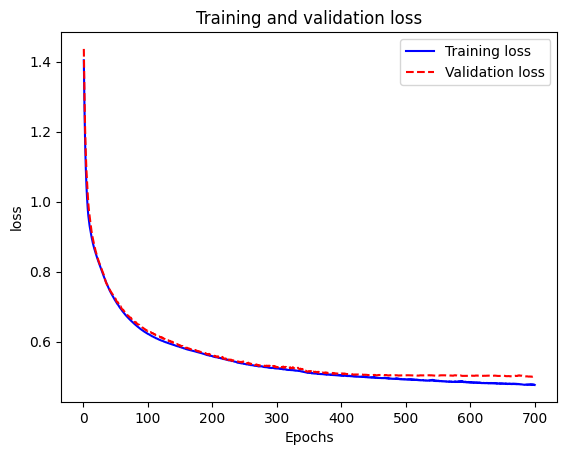

In [17]:
plot_no_dots(history)

In [18]:
# Call evaluate
result = model.evaluate(ds_test, verbose=0) 
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[0.6729050278663635, 0.7674501538276672]


## L2.5. Using Dropout

In [19]:
# We indicate the loss function, the optimization algorithm and the metrics to evaluate performance. 
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)
metric = keras.metrics.AUC()

In [20]:
input_size = 24
h0_size = 20
h1_size = 10
h2_size = 5

# Define the Sequential model
model = keras.Sequential()

# Include the input layer 
model.add(layers.Input(shape=(input_size,)))

# Include all other Dense and Dropout layers
model.add(layers.Dense(units=h0_size, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=h1_size, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=h2_size, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=1, activation='sigmoid'))

# We build the model and we show it
model.build()
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771 (3.01 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# Indicate the parameters of the compile method
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [22]:
num_epochs = 500
# Train the model
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, verbose=0)

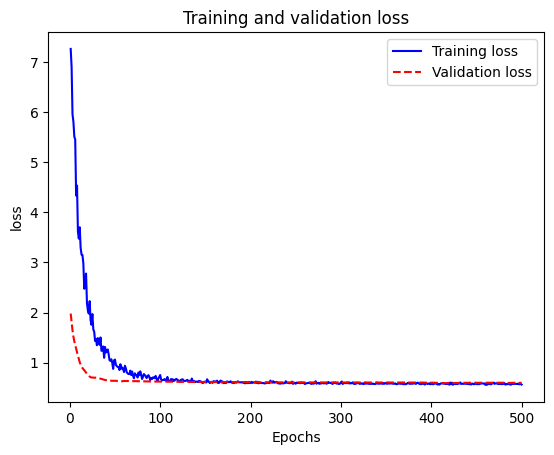

In [23]:
plot_no_dots(history)

In [24]:
# Call evaluate
result = model.evaluate(ds_test, verbose=0) 
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[0.6284847259521484, 0.634861946105957]


## L2.6. Using Batch Normalization

In [25]:
# We indicate the loss function, the optimization algorithm and the metrics to evaluate performance. 
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)
metric = keras.metrics.AUC()

In [26]:
input_size = 24
h0_size = 20
h1_size = 10
h2_size = 5

# Define the Sequential model
model = keras.Sequential()

# Include the input layer 
model.add(layers.Input(shape=(input_size,)))

# Include all other Dense and Batch Normalization layers
model.add(layers.Dense(units=h0_size, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=h1_size, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=h2_size, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=1, activation='sigmoid'))

# We build the model and we show it
model.build()
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5)                   │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 911 (3.56 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 70 (280.00 B)

None


In [27]:
# Indicate the parameters of the compile method
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [28]:
num_epochs = 500
# Train the model
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, verbose=0)

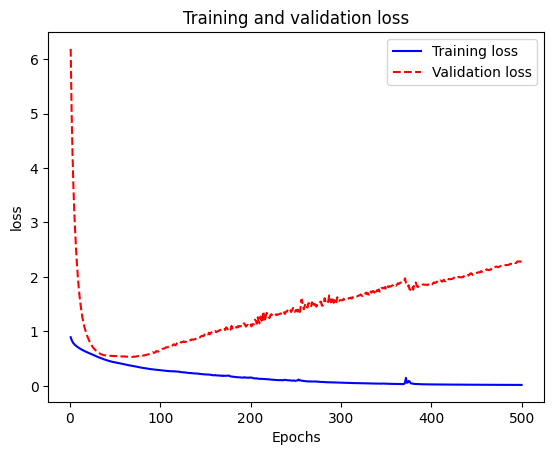

In [29]:
plot_no_dots(history)

In [30]:
# Call evaluate
result = model.evaluate(ds_test, verbose=0) 
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[1.9027304649353027, 0.6389345526695251]


## L2.7. Comments

### Summary Table of Results

| Configurazione Modello | Loss (Test) | AUC (Test) | Epoche Trained | Notes |
| :--- | :--- | :--- | :--- | :--- |
| 1. Basic Sequential | 0.7654 | 0.7238 | 700 | Baseline senza regolarizzazione |
| 2. With EarlyStopping | 0.6749 | 0.7398 | ~400 | Fermato in anticipo per prevenire overfitting |
| 3. L2 Regularization ($\alpha=0.01$) | 0.6729 | 0.7675 | 700 | Penalità sui pesi aggiunta alla loss |
| 4. Dropout (rate=0.5) | 0.6285 | 0.6349 | 500 | Disattivazione casuale dei neuroni |
| 5. Batch Normalization | 1.9027 | 0.6389 | 500 | Attivazioni normalizzate tra i layer |

### Comments on Results

**Regularization Techniques Impact:**

1. **Basic Model**: The baseline model may show signs of overfitting, with training loss continuing to decrease while validation loss plateaus or increases.

2. **EarlyStopping**: This technique monitors validation loss and stops training when it stops improving, preventing the model from overfitting to the training data. It's a simple yet effective approach that doesn't modify the model architecture.

3. **L2 Regularization**: By adding a penalty term proportional to the square of the weights (controlled by $\alpha=0.01$), this technique discourages large weights and promotes simpler models. It helps reduce overfitting by constraining the model's capacity.

4. **Dropout**: With a dropout rate of 0.5, half of the neurons are randomly deactivated during each training step. This forces the network to learn more robust features and prevents co-adaptation of neurons, significantly reducing overfitting.

5. **Batch Normalization**: This technique normalizes the inputs of each layer, which stabilizes and accelerates training. It can also have a mild regularization effect and often allows for higher learning rates.

**General Observations:**
- Regularization techniques generally improve generalization by reducing the gap between training and validation performance.
- The choice of regularization method depends on the specific problem and model architecture.
- Combining multiple regularization techniques (e.g., Dropout + L2) can sometimes yield even better results.
- The AUC metric on the test set provides the final measure of model performance for this binary classification task.